In [1]:
!git clone https://github.com/WaShindeiru/ResidualAttentionNetwork-pytorch
!mv ResidualAttentionNetwork-pytorch temp

Cloning into 'ResidualAttentionNetwork-pytorch'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 202 (delta 10), reused 17 (delta 9), pack-reused 175 (from 1)
Receiving objects: 100% (202/202), 142.61 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Updating files: 100% (9/9), done.


In [26]:
from temp.model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel

In [27]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root='./data_mnist_train',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data_mnist_test',
    train=False,
    download=True,
    transform=transform
)

In [28]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [29]:
images, labels = next(iter(train_loader))
# 64, 1, 28, 28
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


In [30]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


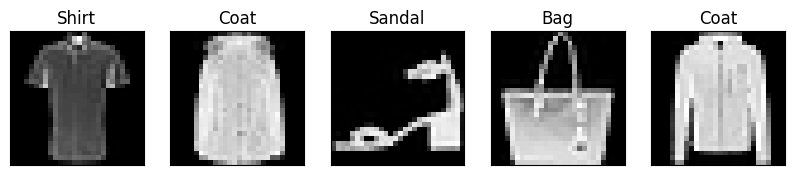

In [31]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(10, 4))
for idx in range(5):
    print(images[idx].shape)
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.set_title(class_names[labels[idx].item()])
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttentionModel().to(device)
# print(model)

lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=lr
)

total_epochs = 10
best_acc = 0.0

for epoch in range(total_epochs):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}", leave=False)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch + 1}/{total_epochs}] | "
        f"Loss: {running_loss / len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {epoch_time:.2f}s"
    )

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [17]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import time
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
from temp.model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel

model_file = './temp/model_92_sgd.pkl'


# for test
def test(model, test_loader, btrain=False, model_file='./temp/model_92_sgd.pkl'):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    model.eval()

    correct = 0
    total = 0
    #
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for images, labels in test_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        for i in range(20):
            label = labels.data[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return correct / total


# Image Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
    # transforms.Scale(224),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])
# when image is rgb, totensor do the division 255
# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root='./data_mnist/',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='./data_mnist/',
                              train=False,
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, # 64
                                           shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=20,
                                          shuffle=False)

images, labels = next(iter(train_loader))
# 64, 1, 28, 28
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model = ResidualAttentionModel().cuda()
print(model)

lr = 0.1  # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
is_train = True
is_pretrain = False
acc_best = 0
total_epoch = 300
if is_train is True:
    if is_pretrain == True:
        model.load_state_dict((torch.load(model_file)))
    # Training
    for epoch in range(total_epoch):
        model.train()
        tims = time.time()
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.cuda())
            # print(images.data_mnist)
            labels = Variable(labels.cuda())

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print("hello")
            if (i+1) % 100 == 0:
                print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" % (epoch+1, total_epoch, i+1, len(train_loader), loss.item()))
        print('the epoch takes time:',time.time()-tims)
        print('evaluate test set:')
        acc = test(model, test_loader, btrain=True)
        if acc > acc_best:
            acc_best = acc
            print('current best acc,', acc_best)
            torch.save(model.state_dict(), model_file)
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
    # Save the Model
    torch.save(model.state_dict(), 'last_model_92_sgd.pkl')

else:
    test(model, test_loader, btrain=False)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
ResidualAttentionModel_92_32input_update(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (residual_block1): ResidualBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fals

KeyboardInterrupt: 